### Configuration

In [1]:
import numpy as np
import scipy.linalg as spl
from typing import Tuple, List, Optional, Union

%matplotlib inline
import matplotlib.pyplot as plt

### Generate Matrix

In [2]:
def generate_matrix(ncols: int, nrows: int):
    #return np.random.uniform(low=0.00000001, high=1.0, size=(nrows, ncols))
    return np.random.randint(1, 9, size=(nrows, ncols))

### Tree Classes

In [3]:
class TreeBase():
    def __init__(self) -> None:
        self.size: Optional[Tuple(float, float, float, float)] = 0
        self.rank: int = 0

class TreeLeaf(TreeBase):
    def __init__(self) -> None:
        super().__init__()
        self.singular_values: float = 0
        self.U: np.ndarray = None
        self.V: np.ndarray = None


class TreeSplit(TreeBase):
    def __init__(self) -> None:
        super().__init__()
        self.left_upper: TreeNode= None
        self.right_upper: TreeNode = None
        self.left_lower: TreeNode = None
        self.right_lower: TreeNode = None

TreeNode = Union[TreeLeaf, TreeSplit]

### SVD

In [4]:
def truncatedSVD(A, r):
    rank = min(r, A.shape[0], A.shape[1])
    u, s, v = spl.svd(A)
    u = u[:, 0:rank]
    v = v[0:rank, :]
    s = s[0:rank]
    return u, s, v

### Matrix Compress

In [5]:
def consist_of_zeros(A):
    return np.all(A==0)

def compress_matrix(A: np.ndarray, first_row: int, last_row: int, first_col: int, last_col: int, r: int) -> TreeLeaf:
    v = TreeLeaf()
    v.size = (first_row, last_row, first_col, last_col)
    U, D, V = truncatedSVD(A, r + 1)
    if consist_of_zeros(A):
        v.rank = 0
    else:
        v.rank = r
        v.singular_values = D[0 : r]
        v.U = U[:, 0 : r]
        v.V =  V[0 : r, :]
    return v



### CreateTree

In [6]:
def create_tree(A: np.ndarray, first_row: int, last_row: int, first_col: int, last_col: int, r: int, eps: float) -> TreeNode:
    new_A = A[first_row : last_row, first_col : last_col]
    U, D, V = truncatedSVD(new_A, r + 1)
    if r + 1 > D.shape[0] or D[r] < eps:
        if D.shape[0] <= 2:
            v = compress_matrix(new_A, first_row, last_row, first_col, last_col, 1)
        else:
            v = compress_matrix(new_A, first_row, last_row, first_col, last_col, r)
    else:
        v = TreeSplit()
        middle_row = (first_row + last_row) // 2
        middle_col = (first_col + last_col) // 2
        v.left_upper = create_tree(A, first_row, middle_row, first_col, middle_col, r, eps)
        v.right_upper = create_tree(A, first_row, middle_row, middle_col, last_col, r, eps)
        v.left_lower = create_tree(A, middle_row, last_row, first_col, middle_col, r, eps)
        v.right_lower = create_tree(A, middle_row, last_row, middle_col, last_col, r, eps)
    return v

### Decompose tree to matrix

In [7]:
def decompose_tree(root: TreeNode) -> np.ndarray:
    if isinstance(root, TreeLeaf):
        if root.rank == 0:
            row_size = root.size[1] - root.size[0]
            col_size = root.size[3] - root.size[2]
            return np.zeros((row_size, col_size))
        else:
            return root.U @ (root.singular_values * np.identity(len(root.singular_values))) @ root.V
    else:
        M11 = decompose_tree(root.left_upper)
        M21 = decompose_tree(root.left_lower)
        M12 = decompose_tree(root.right_upper)
        M22 = decompose_tree(root.right_lower)
        return np.concatenate(
        [np.concatenate([M11, M12], axis=1),
         np.concatenate([M21, M22], axis=1)],
        axis=0,)


### Create matrix to display tree

In [8]:
def tree_to_draw_matrix(root: TreeNode) -> np.ndarray:
    if isinstance(root, TreeLeaf):
        row_size = root.size[1] - root.size[0]
        col_size = root.size[3] - root.size[2]
        if root.rank == 0:
            return np.zeros((row_size, col_size))
        else:
            M = np.zeros((row_size, col_size))
            for i in range(root.rank):
                for row in range(row_size):
                    M[row, i] = 1 
                for col in range(col_size):
                    M[i, col] = 1
            return M
                
    else:
        M11 = tree_to_draw_matrix(root.left_upper)
        M21 = tree_to_draw_matrix(root.left_lower)
        M12 = tree_to_draw_matrix(root.right_upper)
        M22 = tree_to_draw_matrix(root.right_lower)
        return np.concatenate(
        [np.concatenate([M11, M12], axis=1),
         np.concatenate([M21, M22], axis=1)],
        axis=0,)

### Draw matrix

In [9]:
def draw_tree(root: TreeNode):
    M = tree_to_draw_matrix(root)
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    where_0 = np.where(M == 0)
    where_1 = np.where(M == 1)
    M[where_0] = 1
    M[where_1] = 0
    plt.imshow(M, cmap='gray')

### Compare results to function

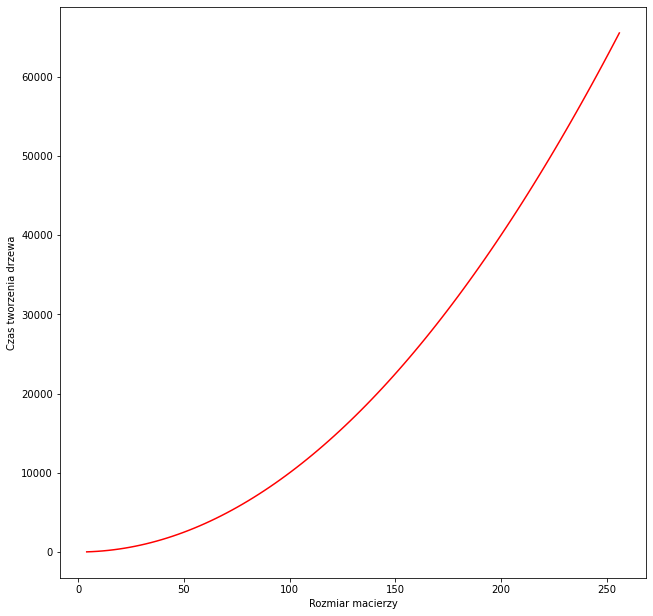

In [10]:
f = lambda x: 1*x**2 + 1

def compare_to_function(x, y, f):
    min_x = min(x)
    max_x = max(x)
    x_function = np.linspace(min_x, max_x, 100)
    y_function = list(map(f, x_function))
    fig = plt.figure()
    fig.set_size_inches(10.5, 10.5)
    plt.plot(x_function, y_function, 'r-')
    plt.xlabel('Rozmiar macierzy')
    plt.ylabel('Czas tworzenia drzewa')
    

compare_to_function([4, 16, 64, 256], [], f)

### Tests

In [11]:
A = generate_matrix(128, 128)
def compress(A, r, eps) -> TreeNode:
    return create_tree(A, 0, A.shape[0], 0, A.shape[1], r, eps)
    
node = compress(A, 1, 5)


In [12]:
print(A)

[[4 4 7 ... 1 3 8]
 [7 4 4 ... 2 7 6]
 [2 1 4 ... 6 6 6]
 ...
 [6 5 8 ... 6 6 7]
 [1 1 6 ... 7 3 8]
 [4 7 8 ... 3 7 1]]


In [13]:
decompose_tree(node)

array([[4.57490524, 3.17041147, 6.08644922, ..., 1.59259277, 4.85689763,
        6.6422033 ],
       [6.6015904 , 4.57490524, 5.09197032, ..., 0.76284808, 5.29756454,
        7.2448512 ],
       [0.50758989, 1.50375908, 4.        , ..., 5.92210776, 6.96685855,
        4.50467048],
       ...,
       [4.41406597, 5.26826143, 7.52803481, ..., 5.15606139, 5.74632414,
        7.20239162],
       [2.44907686, 2.92301413, 4.17681476, ..., 5.54145696, 3.        ,
        8.        ],
       [5.05193211, 6.02956533, 8.61589317, ..., 4.71441339, 7.        ,
        1.        ]])

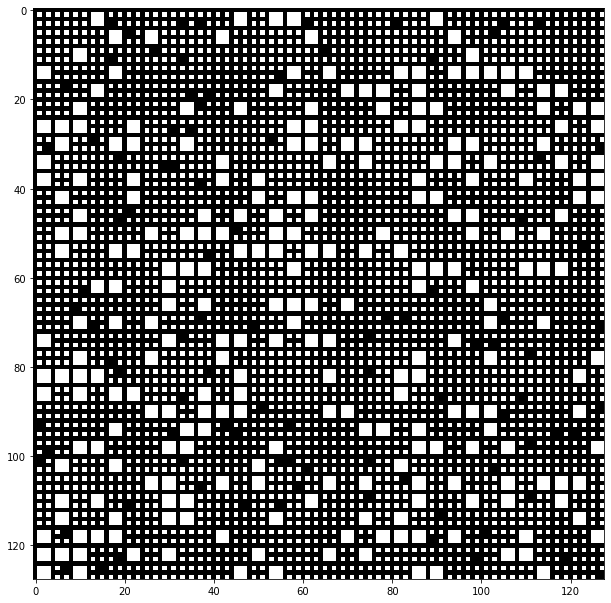

In [14]:
draw_tree(node)
